In [1]:
from IPython.core.display import HTML
HTML("<style>@import url('SamHo_custom.css');</style>")

<h1 align = "center">
    The effects of acute nutrient starvation on the cytoplasmic diffusivity of the $\mu$NS particles in <em>Escherichia coli</em>.
</h1>
<br>
<div align="center", style="font-size:20px">
    Samuel Ho$^{1}$, Alexandros Papagiannakis$^{1, 2, 3}$, Christine Jacobs-Wagner$^{1,2,3,4}$
</div>

<br>
<div align="center", style="font-size:15px">
    <ul>
        $^{1}$ Howard Hughes Medical Institute, Stanford University, Stanford, CA 94305, USA
        </ul>
    <ul>
        $^{2}$ Sarafan Chemistry, Engineering, and Medicine for Human Health Institute, Stanford University, Stanford,
        CA 94305, USA
        </ul>
    <ul>
        $^{3}$ Department of Biology, Stanford University, Stanford, CA 94305, USA
        </ul>
    <ul>
        $^{4}$ Department of Microbiology and Immunology, School of Medicine, Stanford, CA 94305, USA 
        </ul>
</div>


<br>
<h2 align = "left">
    Introduction and experimental methodology
</h2>
<br>
<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
    In this analysis notebook we quantify the changes in cytoplasmic fluidity upon acute carbon starvation in <em>Escherichia coli</em>. The cytoplasmic fluidity is quantified by tracking the $\mu$NS particles (Parry <em>et al</em>, 2014), expressed from a chromosomically-integrated gene copy upon induction with isopropyl-$\beta$-D-thiogalactopyranoside (IPTG). The $\mu$NS particles were analyzed and segmented using a custom analysis pipeline in Python (https://github.com/alexSysBio/Single_particle_tracking). Exponentially growing CJW6723 cells (Xiang <em>et al</em>, 2021) in M9 medium supplemented with 0.2% glycerol and 0.2% casamino acids (M9glyCAAT), were switched to M9 salts without carbon sources. Stream acquisition of the particle positions were performed 3, 27 and 48 hours after carbon source removal, with a frame interval of 50msec. Cell growth and imaging was performed at 30$^o$C. Cells treated with 1mM Carbonyl Cyanide m-Chlorophenylhydrazine (CCCP) were used as a control of inhibited metabolic activity.
</div>


In [2]:
import pandas as pd
import sys
sys.path.append(r"D:\Shares\Data_01\Alex Papagiannakis\Python\Analysis_functions\Sam_Ho_ananlysis")
import data_plotting as dplot
import gaussian_statistics as gaus
import filtering_good_trajectories as filt
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
msd_df_3h = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\Carbon starvation\3 h carbon starvation\50 ms time resolution\msd_all", compression='zip')
msd_df_27h = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\Carbon starvation\27 h carbon starvation\50 ms time resolution\27h_carbon_starv_msd_all", compression='zip')
msd_df_48h = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\Carbon starvation\48 h carbon starvation\50 ms time resolution\msd_all_positions", compression='zip')
msd_df_exp = pd.read_pickle(r"D:\Shares\Data_01\Alex Papagiannakis\Microscopy\muNS\HDR_sensor\50percent_light_300frames\300frames_GlyCAAT_50msec_50uM_CJW6723_30oC\300_frames_GlyCAAT_50msec_results\msd_all_df", compression='zip')
msd_df_ccp = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\External perturbations\1 mM CCCP treatment\50 ms time resolution\CCCP_msd_all", compression='zip')

track_df_3h = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\Carbon starvation\3 h carbon starvation\50 ms time resolution\tracked particles_all", compression='zip')
track_df_27h = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\Carbon starvation\27 h carbon starvation\50 ms time resolution\27h_carbon_starv_tracked_particles_all", compression='zip')
track_df_48h = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\Carbon starvation\48 h carbon starvation\50 ms time resolution\tracked_particles_all", compression='zip')
track_df_exp = pd.read_pickle(r"D:\Shares\Data_01\Alex Papagiannakis\Microscopy\muNS\HDR_sensor\50percent_light_300frames\300frames_GlyCAAT_50msec_50uM_CJW6723_30oC\300_frames_GlyCAAT_50msec_results\track_all_df", compression='zip')
track_df_ccp = pd.read_pickle(r"K:\Previous_members_C\Samuel Ho\other\eGFP-µNS\External perturbations\1 mM CCCP treatment\50 ms time resolution\CCCP_tracked_particles_all", compression='zip')

In [4]:
msd_df_exp['particle_complex'] = msd_df_exp.particle
track_df_exp['particle_complex'] = track_df_exp.particle_trajectory_id
particle_id_list = track_df_exp.particle_complex.unique()
random.seed(1)
sampled_particle_ids = random.choices(particle_id_list, k=1500)
msd_df_exp = msd_df_exp[msd_df_exp.particle_complex.isin(sampled_particle_ids)]
track_df_exp = track_df_exp[track_df_exp.particle_complex.isin(sampled_particle_ids)]

<h2 align = "left">
    Data analysis
</h2>
<h3 align = "left">
    Filtering long Gaussian-like trajectories
</h3>
<br>
<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
    The tracked $\mu$NS trajectories were curated using two conditions: First, only the trajectories that are loger than 149 frames (or 7.5 seconds) were consider. Second, we only considered trajectories that appear Gaussian-like, with a non-Gaussian parameter (also known as $\alpha_{2}$) below a value of 2. We have systematically observed that single particles with unusually high $\alpha_{2}$ (i.e., above 2), corresponds to badly tracked traces. 
</div>
<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
    The non-Gaussian parameter is calculated using the followig mathematical equation:
</div>
<div align = "center", style="font-size:22px; 
            ">
    <br>
        $\alpha_{2} = \frac{|dx^{4}|}{2{|dx^{2}|}^{2}}$ - 1</div>
<br>
<div style="font-size:18px; 
           text-align:justify;">
    , which described the fourth moment of the displacement distribution relative to the its second moment, and is equal to 1 for displacements that follow a Gaussian behavior. Borader distributions return values above 1 (Parry <em>et al</em>, 2014).
</div>

933 trajectories with Gaussian behavior and 22 with non-Gaussian behavior, longer than 149 frames


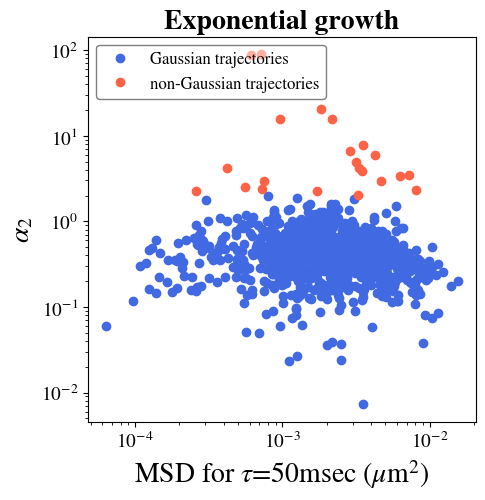

608 trajectories with Gaussian behavior and 65 with non-Gaussian behavior, longer than 149 frames


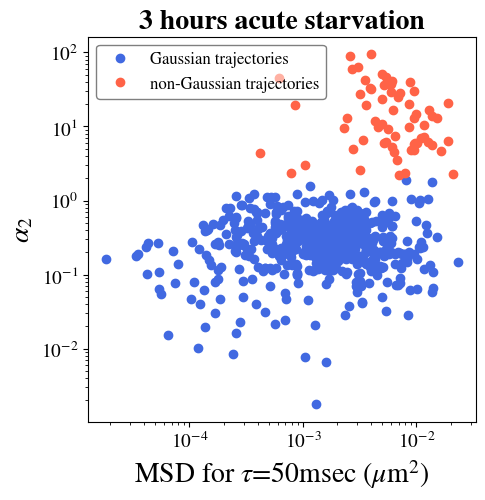

1244 trajectories with Gaussian behavior and 191 with non-Gaussian behavior, longer than 149 frames


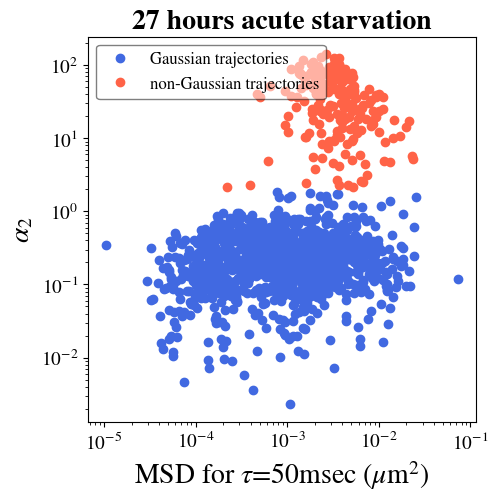

369 trajectories with Gaussian behavior and 134 with non-Gaussian behavior, longer than 149 frames


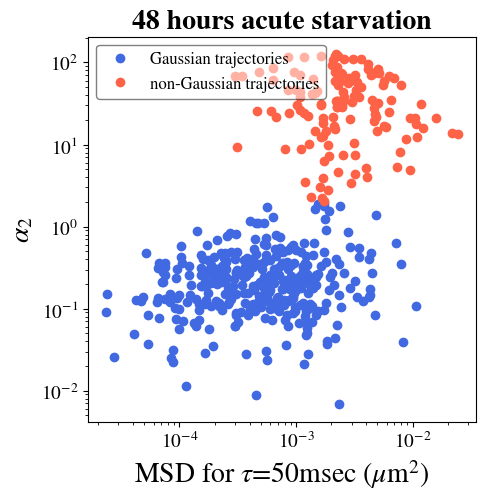

308 trajectories with Gaussian behavior and 44 with non-Gaussian behavior, longer than 149 frames


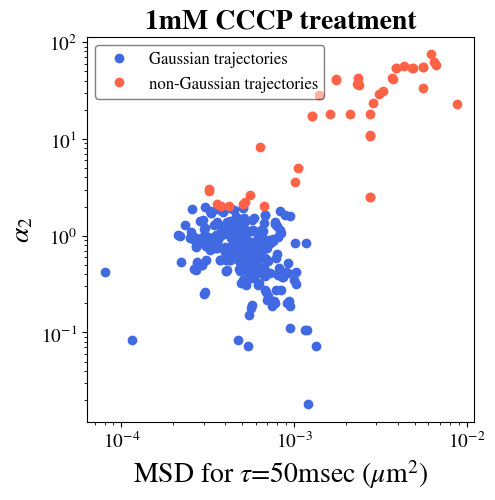

In [5]:
gaus_df_exp = filt.filter_long_gaussian_trajectories(track_df_exp, msd_df_exp, 'Exponential growth', 150, 2)
gaus_df_3h = filt.filter_long_gaussian_trajectories(track_df_3h, msd_df_3h, '3 hours acute starvation', 150, 2)
gaus_df_27h = filt.filter_long_gaussian_trajectories(track_df_27h, msd_df_27h, '27 hours acute starvation', 150, 2)
gaus_df_48h = filt.filter_long_gaussian_trajectories(track_df_48h, msd_df_48h, '48 hours acute starvation', 150, 2)
gaus_df_ccp = filt.filter_long_gaussian_trajectories(track_df_ccp, msd_df_ccp, '1mM CCCP treatment', 150, 2)

<h3 align = "left">
    Statistical analysis of the Gaussian-like and long particle trajectories
</h3>
<br>
<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
    The mean squared displacement (MSD) was calculated as the time-averaged MSD for each trajectory and time interval ($\tau$), from 50msec which is the frame interval to the maximum length of the trajectory (150 to 300 frames, or 7.5 to 15 sec):
</div>

$$
\text{MSD}(\tau) = \frac{1}{N - \tau} \sum_{i=1}^{N - \tau} \left[ (x_{i+\tau} - x_i)^2 + (y_{i+\tau} - y_i)^2 \right]
$$

<br>
<div style="font-size:18px; 
           text-align:justify;">
    where $N$ is the total number of frames and $x_{i},y_{i}$ are the coordinates at time-point $i$. The slope of the MSD versus $\tau$ in the log-log plot is known as the anomalous exponent ($\alpha$) and is equal to 1 for freely diffusing tracer particles. Values of $\alpha$ below 1, indicate sub-diffusion, and when the anomalous exponent is equal to zero, then the particle is practically immobile.
</div>



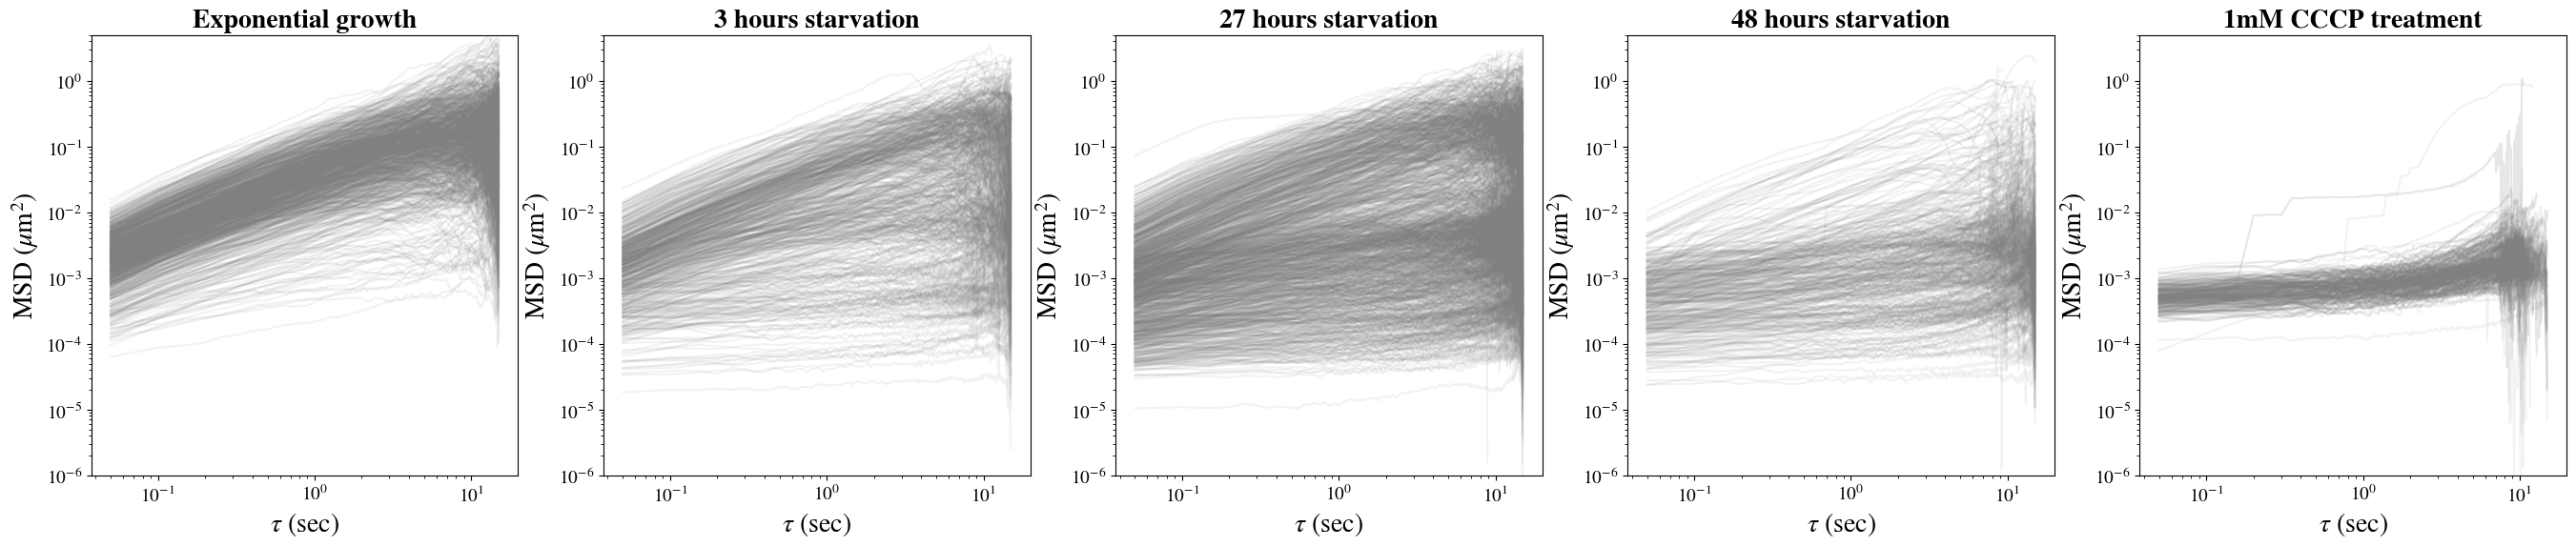

In [6]:
msd_df_list= [msd_df_exp[msd_df_exp.particle_complex.isin(gaus_df_exp.particle_complex)],
            msd_df_3h[msd_df_3h.particle_complex.isin(gaus_df_3h.particle_complex)],
             msd_df_27h[msd_df_27h.particle_complex.isin(gaus_df_27h.particle_complex)],
             msd_df_48h[msd_df_48h.particle_complex.isin(gaus_df_48h.particle_complex)],
             msd_df_ccp[msd_df_ccp.particle_complex.isin(gaus_df_ccp.particle_complex)]]

title_list = ['Exponential growth',
            '3 hours starvation',
             '27 hours starvation',
             '48 hours starvation',
             '1mM CCCP treatment']

dplot.plot_all_individual_msds(msd_df_list, title_list)

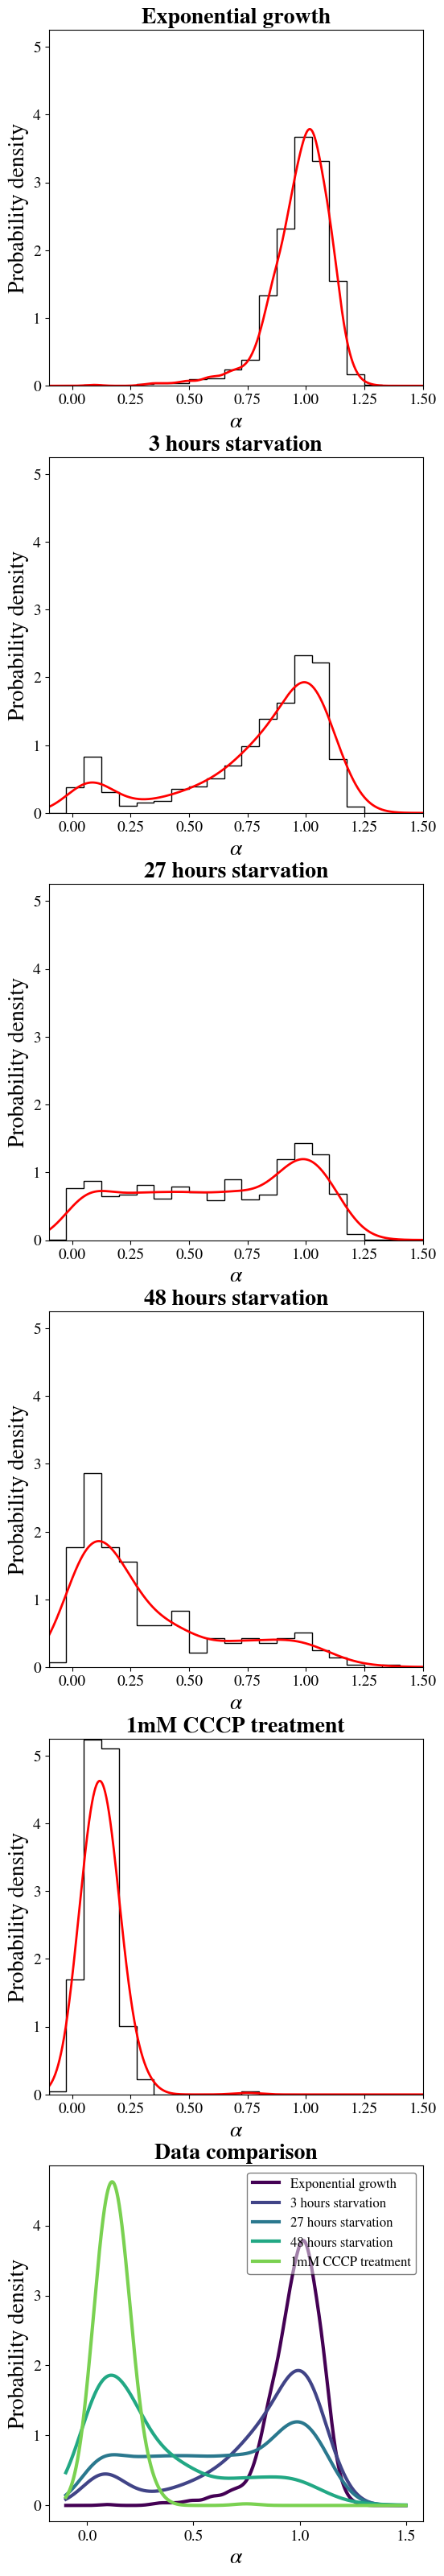

In [7]:
gaus_df_list= [gaus_df_exp, gaus_df_3h, gaus_df_27h, gaus_df_48h, gaus_df_ccp]

title_list = ['Exponential growth',
                '3 hours starvation',
             '27 hours starvation',
             '48 hours starvation',
             '1mM CCCP treatment']

dplot.plot_all_anomalous_exponents(gaus_df_list, title_list, (-0.1,1.5), (0,5.25))

<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
    During acute starvation, we observed a gradual bimodal decrease of the anomalous exponent ($\alpha$) with more and more particles stop moving ($\alpha\approx0$) in the starved cells. In the metabolically inactive CCCP-treated cells, almost the majority of the particles were immobile.
</div>
<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
   To further quantify this decrease in $\mu$NS particle mobility during starvation, we quantified the fraction of moving particles ($\alpha>0.55$) during the course of the experiment. To calculate the error (standard deviation shown as errorbars in the plots below) in our particle fraction calculations, we sampled particle trajecrories and calculated the fraction of moving particles for each sample (50 particle trajectories sample for 1000 rounds).
</div>

In [8]:
boots_dict_exp = gaus.bootstrap_gaussian_stats(gaus_df_exp, 'alpha', 50, 1000, 1)
boots_dict_3h = gaus.bootstrap_gaussian_stats(gaus_df_3h, 'alpha', 50, 1000, 2)
boots_dict_27h = gaus.bootstrap_gaussian_stats(gaus_df_27h, 'alpha', 50, 1000, 3)
boots_dict_48h = gaus.bootstrap_gaussian_stats(gaus_df_48h, 'alpha', 50, 1000, 4)
boots_dict_ccp = gaus.bootstrap_gaussian_stats(gaus_df_ccp, 'alpha', 50, 1000, 5)

In [9]:
alpha_ratios_exp = gaus.collect_alpha_ratios(boots_dict_exp, 0.55)
alpha_ratios_3h = gaus.collect_alpha_ratios(boots_dict_3h, 0.55)
alpha_ratios_27h = gaus.collect_alpha_ratios(boots_dict_27h, 0.55)
alpha_ratios_48h = gaus.collect_alpha_ratios(boots_dict_48h, 0.55)
alpha_ratios_ccp = gaus.collect_alpha_ratios(boots_dict_ccp, 0.55)

In [10]:

all_ratios = [alpha_ratios_exp, alpha_ratios_3h, alpha_ratios_27h, alpha_ratios_48h, alpha_ratios_ccp]
mean_ratio = []
std_ratio = []
for rat in all_ratios:
    mean_ratio.append(np.mean(np.array(rat)*100))
    std_ratio.append(np.std(np.array(rat)*100))

slope, intercept: [-1.44014596 93.10884615]
64.65236785664395 hours required to match the fraction of metabolically inactive CCCP-treated cells


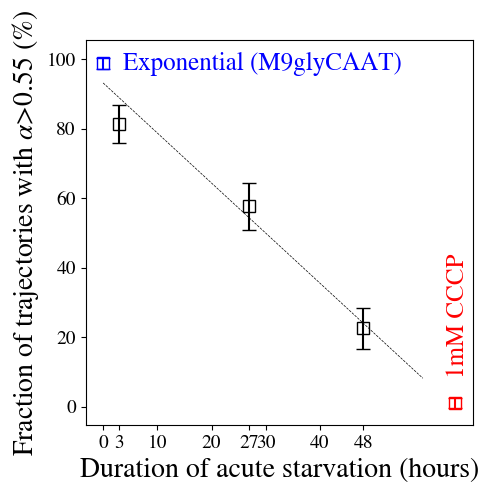

In [11]:
plt.figure(figsize=(5,5))
plt.errorbar([3,27,48], mean_ratio[1:-1], yerr=std_ratio[1:-1], marker='s', markersize=8,
                    markerfacecolor='none', ls='none', color='black', capsize=5)

plt.errorbar([65], mean_ratio[-1], yerr=std_ratio[-1], marker='s', markersize=8,
                    markerfacecolor='none', ls='none', color='red', capsize=5)

plt.errorbar([0], mean_ratio[0], yerr=std_ratio[0], marker='s', markersize=8,
                    markerfacecolor='none', ls='none', color='blue', capsize=5)
linear_fit = np.polyfit([0,3,27,48], mean_ratio[:-1], 1)
print(f"slope, intercept: {linear_fit}")
print(f"{-linear_fit[1]/linear_fit[0]} hours required to match the fraction of metabolically inactive CCCP-treated cells")
plt.plot(np.arange(0,60), np.polyval(linear_fit, np.arange(0,60)), '--', color='black', linewidth=0.5)
plt.xlabel('Duration of acute starvation (hours)')
plt.ylabel(r'Fraction of trajectories with $\alpha$>0.55 (%)')
plt.xticks([0,3,10,20,27,30,40,48])
plt.text(63.3,10,'1mM CCCP', fontsize=18, rotation=90, color='red')
plt.text(3.6,97,'Exponential (M9glyCAAT)', fontsize=18, rotation=0, color='blue')
plt.show()

<div style="font-size:18px; 
            text-indent:2em; text-align:justify;">
   A linear regression was fitted to the average particle fractions during starvation, including the average fraction for the exponential growing cells but excluding the average fraction for the CCCP-treate cells. Our data clearly show that acute carbon starvation negatively impacts the diffusivity of the $\mu$NS particles in the <em>Escherichia coli</em> cytoplasm, Extending on the negative relationship between the duration of acute starvation and the fraction of moving particles (x-intercept) it may take approximately 65 hours for the starved cells to match the metabolically inactive CCCP-treated cells.
</div>


<h2 align = "left">
    References
</h2>
<br>
<div>
    <a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC3956598/"; align="left"; style="font-size:19px">
        Parry BR, Surovtsev IV <em>et al</em>, 2014, PMID: 24361104
    </a>
    <br>
    <a href="https://pubmed.ncbi.nlm.nih.gov/34186018/"; align="left"; style="font-size:19px">
        Xiang Y, Surovtsev IV <em>et al</em>, 2021, PMID: 34186018
    </a>
</div>